# Определение стоимости автомобилей

В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные этапы работы:

- обзор данных
- предобработка и исследовательский анализ данных
- подготовка выборок для обучения и тестирования
- обучение моделей
- анализ моделей и выбор подходящей
- тестирование модели

## Подготовка данных

In [1]:
!pip install -q lightgbm  

In [2]:
!pip install -q catboost 

In [3]:
# импорт библиотек
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
# убираем предупреждения
warnings.filterwarnings('ignore')

### Обзор данных

Загрузим данные и посмотрим на общую информацию о них:

In [5]:
try:
    df = pd.read_csv('dataset.csv')
    
except:
    df = pd.read_csv('/datasets/autos.csv')

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных **имеются пропуски**. Столбцы **DateCrawled, NumberOfPictures, PostalCode и LastSeen не представляют для нас никакого интереса**. Столбцы **DateCreated, RegistrationYear и RegistrationMonth** можно использовать для оценки возраста автомобилей на момент выставления на продажу, поэтому их **пока оставим**:  

In [7]:
df = df.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Также **сменим тип данных для столбца DateCreated**:

In [8]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')

Посмотрим на **количество пропусков** в данных:

In [9]:
pd.DataFrame(df.isna().mean()*100).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,10.579368
RegistrationYear,0.000000
Gearbox,5.596709
Power,0.000000
Model,5.560588
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.282697
Brand,0.000000


Наибольшее число пропусков содержит в себе столбец с информацией о ремонте автомобиля. Также довольно много пропусков в столбцах с типом топлива и формой кузова.

### Предобработка данных

#### Создание столбца с возрастом

**Пропуски имеются только в столбцах VehicleType, Gearbox, Model, FuelType и Repaired**. Значит, **можем оценить возраст для всех объектов**. Для начала извлечём **данные о годе и месяце** выставления на продажу в отдельные столбцы:  

In [10]:
df['year_created'] = df['DateCreated'].dt.year
df['month_created'] = df['DateCreated'].dt.month

Посмотрим **объявления за какие годы имеются** в нашем распоряжении: 

In [11]:
df['year_created'].sort_values().unique()

array([2014, 2015, 2016], dtype=int64)

Посмотрим на **уникальные значения** столбца RegistrationYear, содержащего информацию **о годе выпуска**:

In [12]:
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

**Года раньше 1910** (первые автомобили появились только в конце 19 века), а также **больше 2016 не соответствуют действительности**.

In [13]:
df_real = df.query('1910 < RegistrationYear < 2016')

In [14]:
df_real['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Хотя **0 месяц - не совсем понятная величина**, на возрасте в годах она не должна существенно сказаться (**ошибка определения возраста без учёта месяца не превысит 1 года**):   

In [15]:
df_real['age'] = round((df_real['year_created'] - df_real['RegistrationYear'] - 1) + 
                       (df_real['month_created'] + 12 - df_real['RegistrationMonth']) / 12).astype(int) 

In [16]:
df_real['age'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  71,  72,  73,  74,  75,  76,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  93,  96,
        97, 101])

Несколько подозрительно выглядят автомобили, которым меньше года, однако, **нельзя исключать возможности быстрой перепродажи автомобиля**. Посмотрим, сколько таких примеров имеем:

In [17]:
df_real.query('age == 0').shape[0]

177

Столбцы **year_created, month_created, RegistrationYear, RegistrationMonth и DateCreated более нам не нужны** - удалим их:

In [18]:
df_real = df_real.drop(['year_created', 'month_created', 'RegistrationYear', 'RegistrationMonth', 'DateCreated'],
                       axis=1)

#### Обработка пропусков и аномальных значений

**Для начала** посмотрим какие данные хранятся в **таргете - цене**:

In [19]:
df_real['Price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000], dtype=int64)

**Цены на авто вблизи 0 выглядят, как выбросы**, посмотрим на рапределение в этой области:

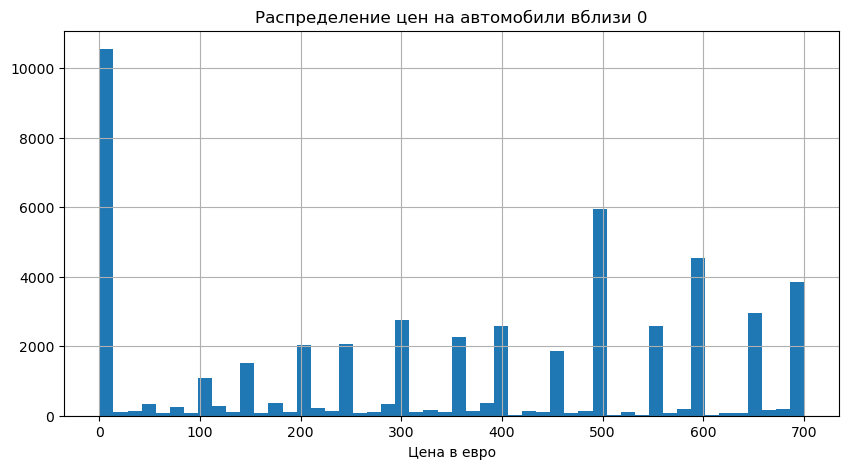

In [20]:
plt.figure(figsize=(10, 5))

df_real['Price'].hist(bins=50, range=(0, 700))

plt.title(label='Распределение цен на автомобили вблизи 0')
plt.xlabel('Цена в евро')
plt.show();

Поскольку **замена значений в таргете может сильно исказить модель**, аномальные значения будет разумнее просто исключить из рассмотрения. **Ограничимся ценами от 500 евро:**

In [21]:
df_real = df_real.query('Price >= 500')

Далее посмотрим какие **модели автомобилей** представлены в наших данных:

In [22]:
df_real['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Моделей довольно много. Посмотрим на их представленность:

In [23]:
df_real['Model'].value_counts()

golf                  23990
other                 21217
3er                   17728
polo                   9805
a4                     9076
                      ...  
samara                    4
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

Есть как широко представленные классы, так и встречающиеся 1-2 раза. Модели **'other' по смыслу никак не особо отличаются от пропусков**. При этом это **вторая по представленности группа**, которую мы **не можем исключить из рассмотрения**. По этой причине логичнее всего будет **заполнить пропуски в данных о модели именно этим значением**: 

In [24]:
df_real['Model'] = df_real['Model'].fillna('other')

Посмотрим какие **типы кузова** представлены:

In [25]:
df_real['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [26]:
df_real['VehicleType'].value_counts()

sedan          85453
small          68202
wagon          60722
bus            27824
convertible    19545
coupe          14832
suv            11704
other           2768
Name: VehicleType, dtype: int64

Здесь также наряду с пропусками **имеется категория 'other', иемнно в неё отправим пропуски**: 

In [27]:
df_real['VehicleType'] = df_real['VehicleType'].fillna('other')

**В столбцах Gearbox, FuelType и Repaired также хранятся неколичественные переменные, пропуски** в которых разумнее будет **заполнить категорией 'other'**. Посмотрим на значения в этих столбцах: 

In [28]:
df_real['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

In [29]:
df_real['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [30]:
df_real['Repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

В FuelType уже существует категория 'other'. **Заполним пропуски**:

In [31]:
for name in ['Gearbox', 'FuelType', 'Repaired']:
    df_real[name] = df_real[name].fillna('other')

**В столбце с брендами пропусков нет**, но посмотрим на них и их представленность в данных: 

In [32]:
df_real['Brand'].value_counts()

volkswagen        63843
bmw               33236
opel              30944
mercedes_benz     29296
audi              26287
ford              19738
renault           13660
peugeot            9405
fiat               7483
seat               5651
skoda              5101
smart              4791
mazda              4683
citroen            4342
toyota             4253
nissan             4070
hyundai            3215
mini               3011
volvo              2809
mitsubishi         2393
sonstige_autos     2388
honda              2357
kia                2177
suzuki             1971
alfa_romeo         1948
chevrolet          1612
chrysler           1221
dacia               849
porsche             677
jeep                618
subaru              612
daihatsu            572
land_rover          522
jaguar              478
saab                474
daewoo              390
trabant             377
lancia              353
rover               341
lada                192
Name: Brand, dtype: int64

**Оставшиеся признаки являются численными и не содержат пропусков, однако стоит проверить их на наличие аномалий**. Посмотрим на **пробег**:

In [33]:
df_real['Kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

Вероятно, что имеющиеся в нашем распоряжении **данные о пробеге представляют собой приближённые значения** - столь круглые значения и наличие определённого шага увеличивающегося при увеличении порядка величины (5, 10, 25 тыс. км) наталкивает на мысль, что это особенность сбора информации. С другой стороны, **сложно говорить о наличие каких-либо аномалий толко по этим числам**. Поскольку данный признак имеет чёткое дробление на категории, **сменим его тип на 'object'**, чтобы далее рассматривать как категориальный:

In [34]:
df_real['Kilometer'] = df_real['Kilometer'].astype('object')

**Посморим на распределение** последнего оставшегося численного признака - **мощности двигателя**:

In [35]:
df_real['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Разброс данных велик, а **некоторые значения выглядят совершенно неправдободобно, вероятно, в данных есть выбросы**. Если очень маленькие единичные значения ещё можно объяснить очень старыми моделя, то мощность более 2000 л.с. не представляется достижимой даже для современных автомобилей. **Посмотрим на распределение в разных диапазонах значений**:

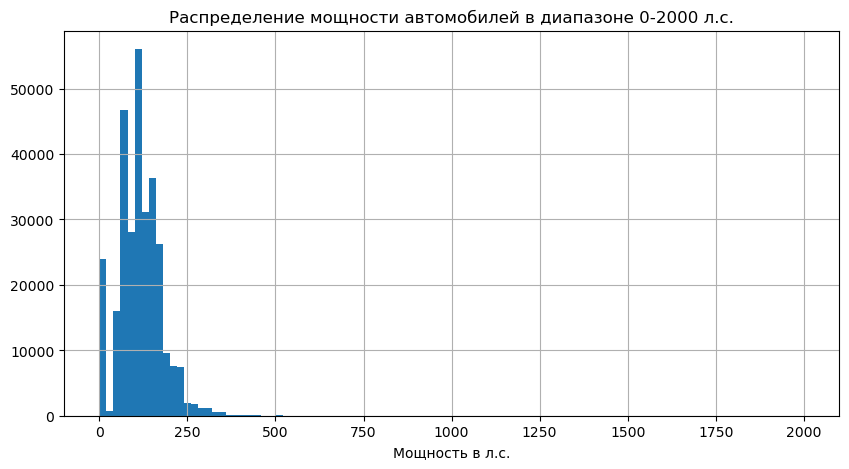

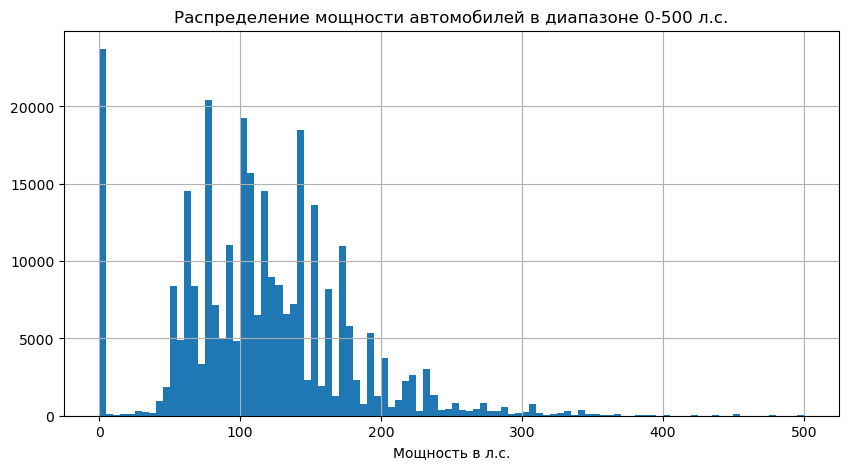

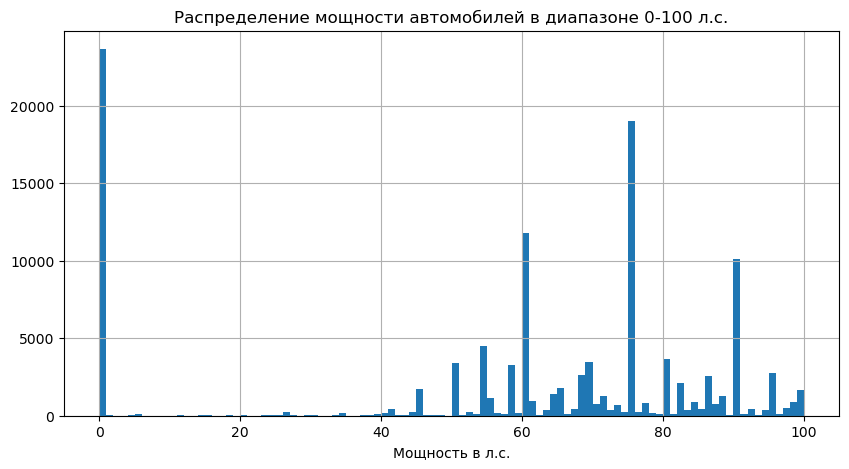

In [36]:
# построение гистограммы в диапозоне 0-2000 л.с.
plt.figure(figsize=(10, 5))

df_real['Power'].hist(bins=100, range=(0, 2000))

plt.title(label='Распределение мощности автомобилей в диапазоне 0-2000 л.с.')
plt.xlabel('Мощность в л.с.')
plt.show();

# построение гистограммы в диапозоне 0-500 л.с.
plt.figure(figsize=(10, 5))

df_real['Power'].hist(bins=100, range=(0, 500))

plt.title(label='Распределение мощности автомобилей в диапазоне 0-500 л.с.')
plt.xlabel('Мощность в л.с.')
plt.show();

# построение гистограммы в диапозоне 0-100 л.с.
plt.figure(figsize=(10, 5))

df_real['Power'].hist(bins=100, range=(0, 100))

plt.title(label='Распределение мощности автомобилей в диапазоне 0-100 л.с.')
plt.xlabel('Мощность в л.с.')
plt.show();

**Значения свыше 250 составляют очень малую часть от всего датасета, при этом значения свыше 500 скорее единичные**. В то же время **пик на 0 игнорировать невозможно**. С одной стороны, это значение не отвечает действительности, с другой - таких значений очень много (почти 25000). **Вероятнее всего, это были пропуски**.

Для начала **оставим только автомобили с мощностью менее 500 л.с.**:  

In [37]:
df_real = df_real.query('Power < 500')

**Заполним нулевые значения медианными значениями мощности для соответствующей модели автомобиля**:

In [38]:
for name in df_real['Model'].unique():
    df_real.loc[(df_real['Power'] == 0) & (df_real['Model'] == name), 'Power'] = \
    df_real.loc[df_real['Model'] == name, 'Power'].median()

**Проверим** датасет также на **наличие явных дубликатов**:

In [39]:
df_real.duplicated().sum()

39931

Дубликатов достаточно много, но тем не менее они **не должны негативно сказаться на обучении моделей, поэтому оставим их**. 

Проверим, что **в данных не осталось пропусков**, а также посмотрим, **какую часть датасета мы потеряли** во время предобработки:

In [40]:
pd.DataFrame(df_real.isna().mean()*100).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
Repaired,0.000000
age,0.000000


In [41]:
round(1 - df_real.shape[0] / df.shape[0], 2)

0.16

Все пропуски были ликвидированы. При этом в процессе предобработки **потеряли 16% исходной выборки**.

## Обучение моделей

Необходимо решить задачу регрессии. Для её решения **воспользуемся регрессорами**, использующими градиентный бустинг **из библиотек LGBM и CatBoost**, а также **моделью случаного леса**. Создадим **обучающие и тестовые выборки с признаками и таргетом**:

In [42]:
# деление на обучающую (85%) и тестовую (15%) выборки: 
features_train, features_test, target_train, target_test = train_test_split(df_real.drop('Price', axis=1), 
                                                                            df_real['Price'], test_size=0.15,
                                                                            random_state=42)

Проверим **корректность разбиения** на выборки:

In [43]:
print(features_train.shape[0], '/', features_test.shape[0], '/', target_train.shape[0], '/', target_test.shape[0])

253280 / 44697 / 253280 / 44697


Нас **интересуют качество (RMSE), а также время обучения и предсказания модели**. Создадим списки и функцию, которые будут собирать эту информацию о выыбранных моделях:

In [44]:
# списки для интересующей информации о моделях
rmse_cv_list = []
fit_time_cv_list = []
score_time_cv_list = []

In [45]:
def model_info(model, features, target):
    
# Считает RMSE для лучшей подобранной модели,  
# сохраняет в список и выводит на экран, тоже делает для
# среднего времени обучения и предсказания модели. 
     
    prediction = model.predict(features)
    rmse = round(mean_squared_error(target, prediction) ** 0.5)
    fit_time = round(model.cv_results_['mean_fit_time'][model.best_index_], 3)
    score_time = round(model.cv_results_['mean_score_time'][model.best_index_], 3)
            
    rmse_cv_list.append(rmse)
    fit_time_cv_list.append(fit_time)
    score_time_cv_list.append(score_time)
    
    return display(f'RMSE: {rmse}', f'Среднее время обучения: {fit_time:.4f}', 
                   f'Среднее время предсказания: {score_time:.4f}')

Для корректной работы моделей также **необходима предварительная подготовка численных и категориальных данных**. Поскольку обучение будем проводить с помощью кросс-валидации **для избежания утечки данных далее будем использовать конвеерную обработку**. Подготовим списки с численными и категориальными данными:    

In [46]:
# списки столбцов с численными и категориальными переменными
numeric = features_train.select_dtypes(exclude=['object']).columns.tolist()
category = features_train.select_dtypes(include=['object']).columns.tolist()

### LGBM регрессор

In [47]:
# создание pipeline для LGBMRegressor
pipe_lgbm = make_pipeline(ColumnTransformer([('num', StandardScaler(), numeric), 
                                             ('cat', OrdinalEncoder(), category)]), 
                          LGBMRegressor(random_state=42))

# сетка параметров для GridSearchCV
param_grid_lgbm = {'lgbmregressor__n_estimators' : [1300, 1400, 1500],
                   'lgbmregressor__max_depth' : [5, 10]}                          

In [48]:
%%time

# подбор лучших гиперпараметров модели кросс-валидацией
GSCV_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv = 5, n_jobs=-1,
                         scoring='neg_root_mean_squared_error')

GSCV_lgbm.fit(features_train, target_train)

CPU times: total: 1min
Wall time: 5min 29s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'age']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'Kilometer',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired'])])),
                                       ('lgbmregressor',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__max_depth': [5, 10],
                         'lgbmregressor__n_estimators': [1300, 1400, 1500]},
             scoring='neg_root_mean_squared_error')

In [49]:
# вывод информации о лучшей модели
model_info(GSCV_lgbm, features_train, target_train)

'RMSE: 1488'

'Среднее время обучения: 46.1930'

'Среднее время предсказания: 41.9070'

### CatBoost регрессор

In [50]:
# создание pipeline для CatBoostRegressor
pipe_cat = make_pipeline(ColumnTransformer([('num', StandardScaler(), numeric), 
                                            ('cat', OrdinalEncoder(), category)]), 
                         CatBoostRegressor(random_state=42))

# сетка параметров для GridSearchCV
param_grid_cat = {'catboostregressor__max_depth' : [5, 10],
                  'catboostregressor__n_estimators' : [1300, 1400, 1500]}

In [51]:
%%time

# подбор лучших гиперпараметров модели кросс-валидацией
GSCV_cat = GridSearchCV(pipe_cat, param_grid_cat, cv = 5, n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

GSCV_cat.fit(features_train, target_train)

Learning rate set to 0.079307
0:	learn: 4326.3257359	total: 214ms	remaining: 4m 38s
1:	learn: 4116.7270417	total: 256ms	remaining: 2m 46s
2:	learn: 3921.6617571	total: 295ms	remaining: 2m 7s
3:	learn: 3752.8521631	total: 325ms	remaining: 1m 45s
4:	learn: 3597.0696544	total: 353ms	remaining: 1m 31s
5:	learn: 3455.2599069	total: 379ms	remaining: 1m 21s
6:	learn: 3330.2111719	total: 407ms	remaining: 1m 15s
7:	learn: 3219.8727222	total: 435ms	remaining: 1m 10s
8:	learn: 3113.9884958	total: 461ms	remaining: 1m 6s
9:	learn: 3022.1529912	total: 486ms	remaining: 1m 2s
10:	learn: 2937.5221068	total: 514ms	remaining: 1m
11:	learn: 2861.8122460	total: 540ms	remaining: 58s
12:	learn: 2793.8473835	total: 567ms	remaining: 56.1s
13:	learn: 2730.8208025	total: 594ms	remaining: 54.6s
14:	learn: 2676.5852559	total: 616ms	remaining: 52.8s
15:	learn: 2626.9254307	total: 643ms	remaining: 51.6s
16:	learn: 2580.5868099	total: 669ms	remaining: 50.5s
17:	learn: 2540.6626156	total: 691ms	remaining: 49.2s
18:	le

159:	learn: 1818.4763934	total: 4.53s	remaining: 32.3s
160:	learn: 1817.5888197	total: 4.56s	remaining: 32.2s
161:	learn: 1816.8599358	total: 4.59s	remaining: 32.2s
162:	learn: 1815.8833490	total: 4.62s	remaining: 32.2s
163:	learn: 1815.1786201	total: 4.65s	remaining: 32.2s
164:	learn: 1814.6398296	total: 4.67s	remaining: 32.1s
165:	learn: 1813.9767512	total: 4.7s	remaining: 32.1s
166:	learn: 1812.7120059	total: 4.74s	remaining: 32.1s
167:	learn: 1811.8279163	total: 4.76s	remaining: 32.1s
168:	learn: 1810.8756269	total: 4.79s	remaining: 32s
169:	learn: 1810.1333643	total: 4.82s	remaining: 32s
170:	learn: 1809.4440840	total: 4.84s	remaining: 32s
171:	learn: 1809.0938636	total: 4.87s	remaining: 32s
172:	learn: 1808.5594077	total: 4.9s	remaining: 31.9s
173:	learn: 1807.7209866	total: 4.92s	remaining: 31.9s
174:	learn: 1806.9388257	total: 4.95s	remaining: 31.8s
175:	learn: 1806.3968342	total: 4.98s	remaining: 31.8s
176:	learn: 1805.6459795	total: 5.01s	remaining: 31.8s
177:	learn: 1804.244

310:	learn: 1738.2254525	total: 8.78s	remaining: 27.9s
311:	learn: 1737.9018070	total: 8.81s	remaining: 27.9s
312:	learn: 1737.5211096	total: 8.83s	remaining: 27.8s
313:	learn: 1737.1350788	total: 8.85s	remaining: 27.8s
314:	learn: 1737.0281627	total: 8.88s	remaining: 27.8s
315:	learn: 1736.5927922	total: 8.91s	remaining: 27.8s
316:	learn: 1736.3644945	total: 8.94s	remaining: 27.7s
317:	learn: 1736.0314607	total: 8.97s	remaining: 27.7s
318:	learn: 1735.6548429	total: 8.99s	remaining: 27.7s
319:	learn: 1735.1039736	total: 9.03s	remaining: 27.7s
320:	learn: 1734.8050026	total: 9.06s	remaining: 27.6s
321:	learn: 1734.5201649	total: 9.08s	remaining: 27.6s
322:	learn: 1734.1838420	total: 9.11s	remaining: 27.6s
323:	learn: 1733.7550736	total: 9.13s	remaining: 27.5s
324:	learn: 1733.4840326	total: 9.17s	remaining: 27.5s
325:	learn: 1733.2395631	total: 9.19s	remaining: 27.5s
326:	learn: 1732.9773681	total: 9.22s	remaining: 27.4s
327:	learn: 1732.5430733	total: 9.26s	remaining: 27.4s
328:	learn

462:	learn: 1696.6335427	total: 13s	remaining: 23.5s
463:	learn: 1696.4272813	total: 13s	remaining: 23.5s
464:	learn: 1696.1838822	total: 13.1s	remaining: 23.5s
465:	learn: 1695.9528996	total: 13.1s	remaining: 23.4s
466:	learn: 1695.6825002	total: 13.1s	remaining: 23.4s
467:	learn: 1695.4385191	total: 13.2s	remaining: 23.4s
468:	learn: 1695.2671979	total: 13.2s	remaining: 23.4s
469:	learn: 1695.0634792	total: 13.2s	remaining: 23.3s
470:	learn: 1694.8450906	total: 13.2s	remaining: 23.3s
471:	learn: 1694.6940456	total: 13.3s	remaining: 23.3s
472:	learn: 1694.5456971	total: 13.3s	remaining: 23.2s
473:	learn: 1694.2809194	total: 13.3s	remaining: 23.2s
474:	learn: 1693.9864237	total: 13.4s	remaining: 23.2s
475:	learn: 1693.7310444	total: 13.4s	remaining: 23.2s
476:	learn: 1693.4881382	total: 13.4s	remaining: 23.2s
477:	learn: 1693.4098265	total: 13.4s	remaining: 23.1s
478:	learn: 1693.2132899	total: 13.5s	remaining: 23.1s
479:	learn: 1693.0623083	total: 13.5s	remaining: 23.1s
480:	learn: 16

613:	learn: 1668.5252420	total: 17.2s	remaining: 19.2s
614:	learn: 1668.4421177	total: 17.2s	remaining: 19.2s
615:	learn: 1668.2493041	total: 17.3s	remaining: 19.2s
616:	learn: 1668.0973284	total: 17.3s	remaining: 19.1s
617:	learn: 1667.9931282	total: 17.3s	remaining: 19.1s
618:	learn: 1667.8608347	total: 17.3s	remaining: 19.1s
619:	learn: 1667.7036711	total: 17.4s	remaining: 19.1s
620:	learn: 1667.5517422	total: 17.4s	remaining: 19s
621:	learn: 1667.4039393	total: 17.4s	remaining: 19s
622:	learn: 1667.1638400	total: 17.5s	remaining: 19s
623:	learn: 1666.9566713	total: 17.5s	remaining: 18.9s
624:	learn: 1666.7908243	total: 17.5s	remaining: 18.9s
625:	learn: 1666.5581229	total: 17.5s	remaining: 18.9s
626:	learn: 1666.4334687	total: 17.6s	remaining: 18.9s
627:	learn: 1666.3115955	total: 17.6s	remaining: 18.8s
628:	learn: 1666.1826507	total: 17.6s	remaining: 18.8s
629:	learn: 1666.1061314	total: 17.7s	remaining: 18.8s
630:	learn: 1665.9854042	total: 17.7s	remaining: 18.7s
631:	learn: 1665

770:	learn: 1646.7213973	total: 21.7s	remaining: 14.9s
771:	learn: 1646.6006724	total: 21.7s	remaining: 14.8s
772:	learn: 1646.4896802	total: 21.7s	remaining: 14.8s
773:	learn: 1646.3540941	total: 21.8s	remaining: 14.8s
774:	learn: 1646.2518053	total: 21.8s	remaining: 14.8s
775:	learn: 1646.1671570	total: 21.8s	remaining: 14.7s
776:	learn: 1646.0009459	total: 21.8s	remaining: 14.7s
777:	learn: 1645.8482490	total: 21.9s	remaining: 14.7s
778:	learn: 1645.7448718	total: 21.9s	remaining: 14.6s
779:	learn: 1645.6415859	total: 21.9s	remaining: 14.6s
780:	learn: 1645.5951222	total: 22s	remaining: 14.6s
781:	learn: 1645.4430708	total: 22s	remaining: 14.6s
782:	learn: 1645.3214845	total: 22s	remaining: 14.5s
783:	learn: 1645.2752659	total: 22s	remaining: 14.5s
784:	learn: 1645.1776611	total: 22.1s	remaining: 14.5s
785:	learn: 1645.1025446	total: 22.1s	remaining: 14.5s
786:	learn: 1645.0263782	total: 22.1s	remaining: 14.4s
787:	learn: 1644.8777382	total: 22.2s	remaining: 14.4s
788:	learn: 1644.7

926:	learn: 1629.7535427	total: 26.1s	remaining: 10.5s
927:	learn: 1629.6804539	total: 26.1s	remaining: 10.5s
928:	learn: 1629.5632240	total: 26.2s	remaining: 10.4s
929:	learn: 1629.4929282	total: 26.2s	remaining: 10.4s
930:	learn: 1629.4156712	total: 26.2s	remaining: 10.4s
931:	learn: 1629.3130197	total: 26.2s	remaining: 10.4s
932:	learn: 1629.2196474	total: 26.3s	remaining: 10.3s
933:	learn: 1629.0672570	total: 26.3s	remaining: 10.3s
934:	learn: 1629.0537437	total: 26.3s	remaining: 10.3s
935:	learn: 1628.9197641	total: 26.4s	remaining: 10.3s
936:	learn: 1628.8618052	total: 26.4s	remaining: 10.2s
937:	learn: 1628.7613181	total: 26.4s	remaining: 10.2s
938:	learn: 1628.6349484	total: 26.4s	remaining: 10.2s
939:	learn: 1628.5522395	total: 26.5s	remaining: 10.1s
940:	learn: 1628.4669696	total: 26.5s	remaining: 10.1s
941:	learn: 1628.4103216	total: 26.5s	remaining: 10.1s
942:	learn: 1628.2674730	total: 26.5s	remaining: 10.1s
943:	learn: 1628.2252354	total: 26.6s	remaining: 10s
944:	learn: 

1077:	learn: 1616.1352678	total: 30.3s	remaining: 6.24s
1078:	learn: 1616.0729992	total: 30.3s	remaining: 6.21s
1079:	learn: 1615.9792357	total: 30.4s	remaining: 6.19s
1080:	learn: 1615.9416647	total: 30.4s	remaining: 6.16s
1081:	learn: 1615.8782327	total: 30.4s	remaining: 6.13s
1082:	learn: 1615.7438807	total: 30.5s	remaining: 6.1s
1083:	learn: 1615.6452737	total: 30.5s	remaining: 6.08s
1084:	learn: 1615.5804423	total: 30.5s	remaining: 6.05s
1085:	learn: 1615.5368364	total: 30.6s	remaining: 6.02s
1086:	learn: 1615.5060981	total: 30.6s	remaining: 5.99s
1087:	learn: 1615.4351710	total: 30.6s	remaining: 5.96s
1088:	learn: 1615.3709359	total: 30.6s	remaining: 5.93s
1089:	learn: 1615.3260331	total: 30.7s	remaining: 5.91s
1090:	learn: 1615.2609778	total: 30.7s	remaining: 5.88s
1091:	learn: 1615.1881323	total: 30.7s	remaining: 5.85s
1092:	learn: 1615.1542900	total: 30.7s	remaining: 5.82s
1093:	learn: 1615.0762193	total: 30.8s	remaining: 5.79s
1094:	learn: 1615.0296153	total: 30.8s	remaining:

1226:	learn: 1604.6637141	total: 34.5s	remaining: 2.05s
1227:	learn: 1604.5803345	total: 34.5s	remaining: 2.02s
1228:	learn: 1604.4571809	total: 34.6s	remaining: 2s
1229:	learn: 1604.3580263	total: 34.6s	remaining: 1.97s
1230:	learn: 1604.3030405	total: 34.6s	remaining: 1.94s
1231:	learn: 1604.0731757	total: 34.6s	remaining: 1.91s
1232:	learn: 1604.0312133	total: 34.7s	remaining: 1.88s
1233:	learn: 1603.9764109	total: 34.7s	remaining: 1.85s
1234:	learn: 1603.8974152	total: 34.7s	remaining: 1.83s
1235:	learn: 1603.8847562	total: 34.8s	remaining: 1.8s
1236:	learn: 1603.7963241	total: 34.8s	remaining: 1.77s
1237:	learn: 1603.7457399	total: 34.8s	remaining: 1.74s
1238:	learn: 1603.6936491	total: 34.9s	remaining: 1.72s
1239:	learn: 1603.6281431	total: 34.9s	remaining: 1.69s
1240:	learn: 1603.5591218	total: 34.9s	remaining: 1.66s
1241:	learn: 1603.4659059	total: 35s	remaining: 1.63s
1242:	learn: 1603.4287733	total: 35s	remaining: 1.6s
1243:	learn: 1603.3429387	total: 35s	remaining: 1.58s
124

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'age']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'Kilometer',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired'])])),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x000001E149299B50>)]),
             n_jobs=-1,
             param_grid={'catboostregressor__max_depth': [5, 10],
                         'catboostregressor__n_estimators': [1300, 1400, 1500]},
             scoring='neg_root_mean_squared_error')

In [52]:
# вывод информации о лучшей модели
model_info(GSCV_cat, features_train, target_train)

'RMSE: 1599'

'Среднее время обучения: 166.6060'

'Среднее время предсказания: 0.5690'

### Модель случайного леса

In [53]:
# создание pipeline для RandomForestRegressor
pipe_forest = make_pipeline(ColumnTransformer([('num', StandardScaler(), numeric), 
                                               ('cat', OrdinalEncoder(), category)]), 
                            RandomForestRegressor(random_state=42))

# сетка параметров для GridSearchCV
param_grid = {'randomforestregressor__max_depth' : [5, 10],
              'randomforestregressor__n_estimators' : [300, 400]}

In [54]:
%%time

# подбор лучших гиперпараметров модели кросс-валидацией
GSCV_forest = GridSearchCV(pipe_forest, param_grid, cv = 5, n_jobs=-1,
                           scoring='neg_root_mean_squared_error')

GSCV_forest.fit(features_train, target_train)

CPU times: total: 2min 7s
Wall time: 19min 16s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'age']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'Kilometer',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [5, 10],
                         'randomforestregressor__n_estimators': [300, 400]},
             scoring='neg_root_mean_squared_error')

In [55]:
# вывод информации о лучшей модели
model_info(GSCV_forest, features_train, target_train)

'RMSE: 2351'

'Среднее время обучения: 288.9440'

'Среднее время предсказания: 1.6580'

## Анализ моделей

**Для наглядности** сравнения различных моделей, **соберём все полученные характеристики** в датафрейм:

In [56]:
# список с названиями моделей
model_list = ['GSCV_lgbm', 'GSCV_cat', 'GSCV_forest']

# создание пустого словаря
model_cv_metrics = {} 

# добавление собранных списков в словарь
model_cv_metrics['model'] = model_list
model_cv_metrics['RMSE'] = rmse_cv_list
model_cv_metrics['fit_time, s'] = fit_time_cv_list
model_cv_metrics['score_time, s'] = score_time_cv_list

# преобразование словаря в датафрейм
model_cv_metrics = pd.DataFrame(data=model_cv_metrics) 
model_cv_metrics.style.background_gradient('coolwarm', axis=0)

,model,RMSE,"fit_time, s","score_time, s"
0,GSCV_lgbm,1488,46.193000,41.907000
1,GSCV_cat,1599,166.606000,0.569000
2,GSCV_forest,2351,288.944000,1.658000


Первое, что привлекает внимание - **модели, использующие градиентный бустинг (GSCV_lgbm и GSCV_cat), значительно быстрее обучаются**, при этом **лучшие показатели** по этому параметру демонстрирует **GSCV_lgbm** (почти в 3 раз быстрее GSCV_cat и в в 5 - GSCV_forest). С другой стороны, **по скорости предсказания GSCV_lgbm значительно уступает остальным моделям**. Высокая скорость обучения позволяет уделить больше времени доработке модели, увеличить число базовых моделей в ней - в частности, качество GSCV_forest, вероятно, можно было бы повысить значительно увеличив число деревьев, входящих в ансамбль, однако время обучения непомерно выросло бы.

**Качество GSCV_lgbm и GSCV_cat достаточно близко, хотя для GSCV_lgbm и удалось получить несколько лучшее значение RMSE. Для дальнейшего тестирования оставим GSCV_lgbm, поскольку она лучшая по двум параметрам - качеству и скорости обучения**. 

В то же время, стоит отметить, что **в случае больших объёмов данных для предсказаний GSCV_cat может показать себя лучше за счёт очень высокой скорости предсказания**.

## Тестирование лучшей модели

Проверим выбранную модель GSCV_lgbm на тестовых данных:

In [57]:
%%time

# предсказание на тестовой выборке
prediction = GSCV_lgbm.predict(features_test)

CPU times: total: 6.41 s
Wall time: 960 ms


In [58]:
# RMSE на тестовой выборке
rmse = mean_squared_error(target_test, prediction) ** 0.5
round(rmse)

1564

**Значение RMSE на тестовых данных несколько ниже, однако модель не выглядит переобученной**.

## Результаты и выводы

На превом этапе обработки данных **удалили неинформативные для обучения столбцы** с информацией о дате скачивания  анкеты, числом фото, почтовым индексом и последним посещением - **DateCrawled, NumberOfPictures, PostalCode и LastSeen**, соответственно. Далее **обработали столбцы DateCreated, RegistrationYear и RegistrationMonth** с информацией о дате выставления на продажу и годом и месяцем регистрации автомобиля - **удалили объекты с аномальным значением года регистрации и рассчитали возраст автомобилей**. После этого **столбцы DateCreated, RegistrationYear и RegistrationMonth удалили как неинформативные**. 

**Аномальные значения обнаружили также в цене и мощности автомобилей. Объекты со слишким низким значением цены (менее 500 евро) удалили**, поскольку это целевой признак. **В случае с мощностью особенно выделялось нулевое значение** - вероятно, пропуски. Их **заполнили медианным значением мощности таких же моделей**. Экстремально большие значения не были представлены широко, поэтому **на основе распределения выбрали границу в 500 л.с. - объекты с большими значениями мощности удалили**.     

**Столбцы с информацией о моделях, типах кузова, коробки передач и топлива, а также информацией о ремонте содержали пропуски**. Поскольку все эти данные по существу категориальные, **заполняли их категорией "other"**. Более того, **в некоторых из столбцов эта категория уже была**, при том достаточно широко представлена. 

Также в данных **обнаружили значительное число явных дубликатов, которые впрочем оставили нетронутыми**, поскольку на обучение они не должны влиять негативно. Таким образом, в ходе предобработки и исследовательского анализа данных было утеряно ~ 16% датасета. 

Перед обучением данные **разбили на  обучающую и тестовую выборки в отношение 85 : 15**. **Подбор параметров и обучение моделей** проводили с помощью **GridSearchCV**. Чтобы избежать утечку данных при кросс-валидации **использовали конвеерную обработку (Pipeline)**, в рамках которой **численные признаки масштабировали с помощью стандартизации, категориальные кодировали методом прямого кодирования, а после передавали в модель**. Для сравнения выбрали **LGBMRegressor, CatBoostRegressor и RandomForestRegressor**, модели **сравнивали по трём показателям - качество (RMSE), время обучения и предсказания**.

**Модели GSCV_lgbm и GSCV_cat**, использующие градиентный бустинг, **значительно быстрее обучаются**, при этом **лучшие показатели по этому параметру демонстрирует GSCV_lgbm**, но **по скорости предсказания GSCV_lgbm значительно уступает остальным моделям**. **Качество GSCV_lgbm и GSCV_cat достаточно близко, хотя для GSCV_lgbm и удалось получить несколько лучшее значение RMSE** (1488 евро). **Для дальнейшего тестирования оставили GSCV_lgbm, поскольку она лучшая по двум параметрам - качеству и скорости обучения**. RMSE на тестовой выборке для GSCV_lgbm составило 1564 евро. 

В то же время, стоит отметить, что **в случае больших объёмов данных для предсказаний GSCV_cat может показать себя лучше за счёт очень высокой скорости предсказания**.